## Overview

The current project involves inpatient, outpatient and beneficiary information. The nature of the dataset provided is claim-oriented while the task we are given is to predict whether the provider is potentially fraudulent or not, which means that the dataset has to be transformed to be provider-oriented. Since none of the columns will be used as they are to fulfill the objectives of the project, exploratory data analysis is considerably necessary in order to create relevant features for providers. The following questions are asked and answered to better understand the dataset, and to create new features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from hashable_df import hashable_df
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)
sns.set(style = "whitegrid")
sns.set_palette("icefire")
pd.set_option('display.max_columns', 500)

## Load Data

In [2]:
patient = joblib.load("patient.pkl")

In [3]:
print(patient.shape)
patient.head()

(558211, 56)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,IsOutpatient,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1943-01-01,NaT,1,1,0,39,230,12,12,1,0,1,0,0,1,1,1,0,1,1,36000,3204,60,70,Yes
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092,NaN,NaN,NaN,NaN,NaN,0,1943-01-01,NaT,1,1,0,39,230,12,12,1,0,1,0,0,1,1,1,0,1,1,36000,3204,60,70,No
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1943-01-01,NaT,1,1,0,39,230,12,12,1,0,1,0,0,1,1,1,0,1,1,36000,3204,60,70,No
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,1068.0,2009-02-22,067,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,331,NaN,NaN,NaN,NaN,NaN,0,1914-03-01,NaT,0,2,0,1,360,12,12,0,1,1,0,0,1,1,0,0,1,1,5000,1068,250,320,No
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893,NaN,NaN,NaN,NaN,NaN,0,1938-04-01,NaT,0,1,1,45,780,12,12,0,1,1,0,1,1,0,1,0,0,0,21260,2136,120,100,No


In [4]:
# Create variables for convenience 
inpatient = patient[patient['IsOutpatient'] == 0]
outpatient = patient[patient['IsOutpatient'] == 1]
diag_code = patient.columns[patient.columns.str.contains('DiagnosisCode')].tolist()
proc_code = patient.columns[patient.columns.str.contains('ProcedureCode')].tolist()
chronic = patient.columns[patient.columns.str.contains("Chronic")].tolist()

## Create Relevant Features and Functions

In [5]:
patient["ClaimDuration"] = patient["ClaimEndDt"] - patient["ClaimStartDt"]
patient["ClaimDuration"] = patient["ClaimDuration"].dt.days
patient["NoPhy"] = patient[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']].isna().all(axis =1)
patient['AllPhy'] = patient[['AttendingPhysician', 'OperatingPhysician']].notnull().all(axis =1)
patient["AdmisDuration"] = patient["DischargeDt"] - patient["AdmissionDt"]
patient["AdmisDuration"] = patient["AdmisDuration"].dt.days
patient["AgeAtClm"] = round((patient["ClaimStartDt"] - patient["DOB"]).dt.days/365,0).astype(int)
patient["TotalRev"] = patient['InscClaimAmtReimbursed'] + patient['DeductibleAmtPaid']
patient['ClmYear'] = patient.ClaimStartDt.dt.year.rename('Year')
patient['ClmMonth'] = patient.ClaimStartDt.dt.month.rename('Month')
patient['ClmWeek'] = patient.ClaimStartDt.dt.week.rename('Week')
patient['InsCovRatio'] = patient['InscClaimAmtReimbursed']/(patient['InscClaimAmtReimbursed'] + patient["DeductibleAmtPaid"])
patient['RevPerDay'] = patient["TotalRev"]/(patient['ClaimDuration']+1)
patient['Chronic_Sum'] = patient[chronic].sum(axis = 1)

In [6]:
# Function for transforming dataframe, which will be used for plotting
def transform_df(agg_col, agg_func, new_colname):
    new_dfname = patient.groupby(['PotentialFraud','IsOutpatient','Provider'])[[agg_col]].agg(agg_func)
    new_dfname.columns.values[0] = new_colname
    new_dfname = new_dfname.reset_index()
    return new_dfname

In [7]:
# Function for creating boxplots grouped by in/out patients and fraudulent providers
def create_boxplot(df, column, title1, title2):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    sns.boxplot(data = df[(df['IsOutpatient'] == 0)], 
                x = column, y = 'PotentialFraud', ax = ax[0], fliersize= 1);
    sns.boxplot(data = df[(df['IsOutpatient'] == 1)], 
                x = column, y = 'PotentialFraud', ax = ax[1], fliersize= 1);
    ax[0].set_title(title1);
    ax[1].set_title(title2);

## Questions of Interest

### How many unique beneficiaries did each provider have?

In [8]:
num_bene = transform_df('BeneID', 'nunique', 'NuniqueBene')

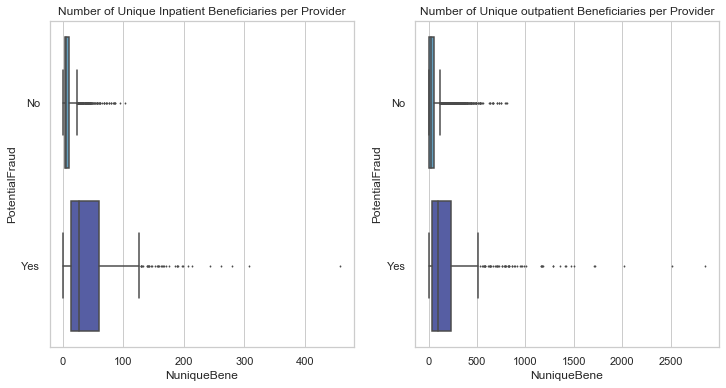

In [9]:
create_boxplot(num_bene, "NuniqueBene",
              "Number of Unique Inpatient Beneficiaries per Provider",
              "Number of Unique outpatient Beneficiaries per Provider")

### How many claims did each provider make?

In [10]:
num_clm = patient.groupby(['PotentialFraud','IsOutpatient','Provider'])[['ClaimID']].size()
num_clm = pd.DataFrame(num_clm, columns = ["Count"]).reset_index()

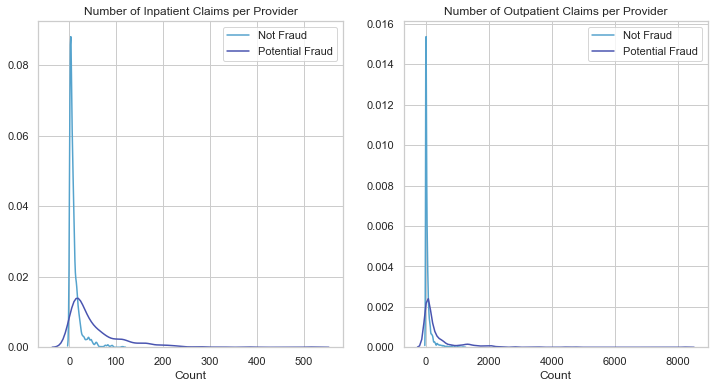

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.distplot(num_clm.loc[(num_clm['IsOutpatient'] == 0) & (num_clm['PotentialFraud'] == "No"),
                         "Count"], hist = False, label = "Not Fraud", ax = ax[0]);
sns.distplot(num_clm.loc[(num_clm['IsOutpatient'] == 0) & (num_clm['PotentialFraud'] == "Yes"),
                         "Count"], hist = False, label = "Potential Fraud", ax = ax[0]);
sns.distplot(num_clm.loc[(num_clm['IsOutpatient'] == 1) & (num_clm['PotentialFraud'] == "No"),
                         "Count"], hist = False, label = "Not Fraud", ax = ax[1]);
sns.distplot(num_clm.loc[(num_clm['IsOutpatient'] == 1) & (num_clm['PotentialFraud'] == "Yes"),
                         "Count"], hist = False, label = "Potential Fraud", ax = ax[1]);
ax[0].set_title("Number of Inpatient Claims per Provider");
ax[1].set_title("Number of Outpatient Claims per Provider");

### What is the mean claim duration?

In [12]:
clm_dur = transform_df('ClaimDuration', 'mean', 'MeanClmDuration')

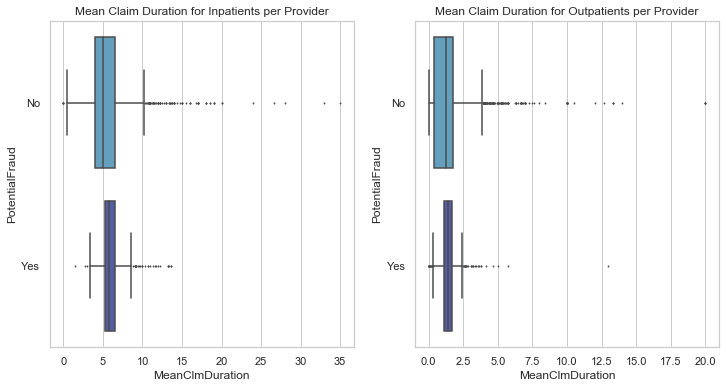

In [13]:
create_boxplot(clm_dur, "MeanClmDuration",
              "Mean Claim Duration for Inpatients per Provider",
              "Mean Claim Duration for Outpatients per Provider")

### What is the total/mean/median amount of reimbursed claims for each provider?

In [14]:
avg_reimb = transform_df('InscClaimAmtReimbursed', 'sum', 'TotalAmtReimbursed')

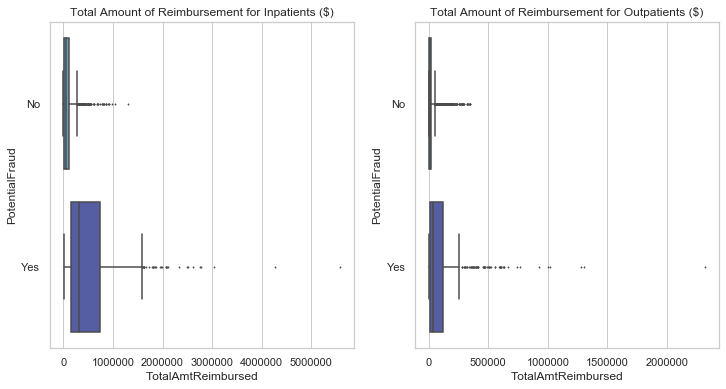

In [15]:
create_boxplot(avg_reimb, "TotalAmtReimbursed",
              "Total Amount of Reimbursement for Inpatients ($)",
              "Total Amount of Reimbursement for Outpatients ($)")

### How many claims did not have any physician involved for providers?

In [16]:
no_phy = transform_df('NoPhy', 'sum', 'ClmWithNoPhy')

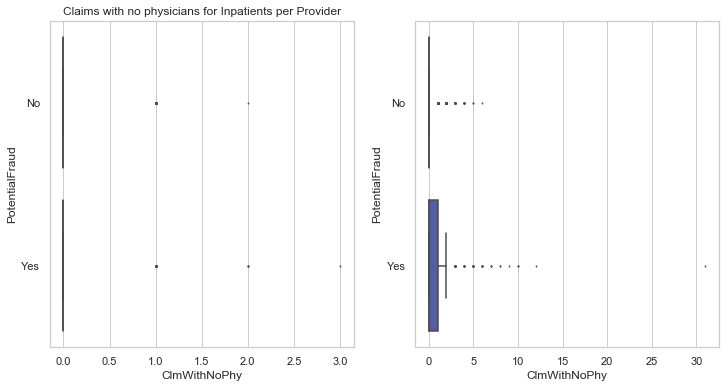

In [17]:
create_boxplot(no_phy, 'ClmWithNoPhy',
              "Claims with no physicians for Inpatients per Provider",
              "")

### How many claims had all physicians involved for providers?

In [18]:
all_phy = transform_df('AllPhy', 'sum', 'ClmWithAllPhy')

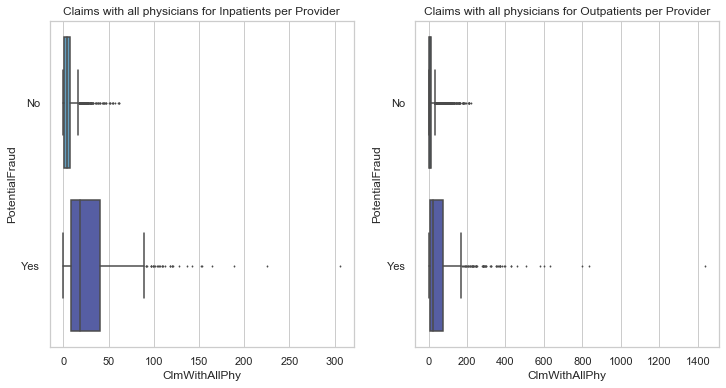

In [19]:
create_boxplot(all_phy, "ClmWithAllPhy",
              "Claims with all physicians for Inpatients per Provider",
              "Claims with all physicians for Outpatients per Provider")

### How many days do inpatients stay in hospitals on average for providers?
* Outpatients are out of consideration since they are never admitted to the hospitals

In [20]:
adm_dur = transform_df('AdmisDuration', 'mean', 'MeanAdmisDuration')

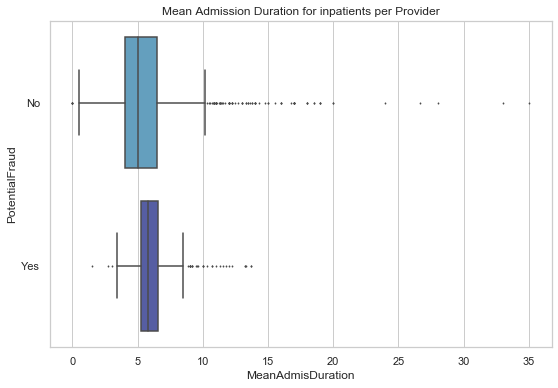

In [21]:
sns.boxplot(data = adm_dur, x = "MeanAdmisDuration", y = 'PotentialFraud', fliersize= 1);
plt.title("Mean Admission Duration for inpatients per Provider");

### What is the total deductible amount of claims for each provider?

In [22]:
avg_deduct = transform_df('DeductibleAmtPaid', 'sum', 'TotalDeductibleAmt')

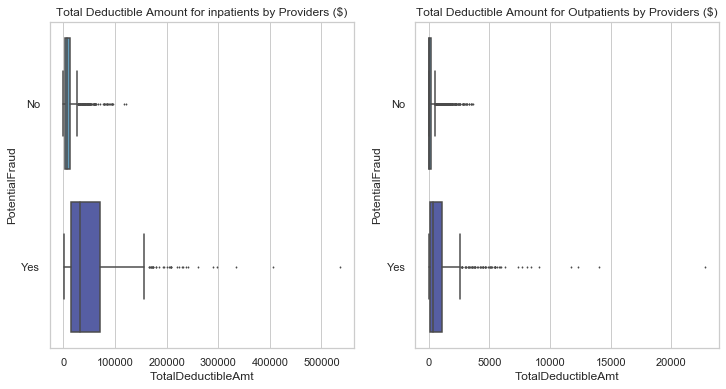

In [23]:
create_boxplot(avg_deduct, "TotalDeductibleAmt",
              "Total Deductible Amount for inpatients by Providers ($)",
              "Total Deductible Amount for Outpatients by Providers ($)")

### How many medical doctors are there in the train outpatient/inpatient dataset?

In [24]:
all_inphy = pd.concat([inpatient["AttendingPhysician"],inpatient["OperatingPhysician"],inpatient["OtherPhysician"]])
print("Unique doctors for inpatients:", all_inphy.nunique())

Unique doctors for inpatients: 18256


In [25]:
all_outphy = pd.concat([outpatient["AttendingPhysician"],outpatient["OperatingPhysician"],outpatient["OtherPhysician"]])
print("Unique doctors for outpatients:", all_outphy.nunique())

Unique doctors for outpatients: 89770


### Do inpatients show worse health conditions (in terms of chronic diseases) than outpatients?

In [26]:
print("Percentage of inpatients with certain chronic disease")
inpatient[chronic].sum()/(inpatient.shape[0])

Percentage of inpatients with certain chronic disease


ChronicCond_Alzheimer              0.504052
ChronicCond_Heartfailure           0.721821
ChronicCond_KidneyDisease          0.601769
ChronicCond_Cancer                 0.190962
ChronicCond_ObstrPulmonary         0.479147
ChronicCond_Depression             0.502224
ChronicCond_Diabetes               0.802046
ChronicCond_IschemicHeart          0.856698
ChronicCond_Osteoporasis           0.351559
ChronicCond_rheumatoidarthritis    0.360355
ChronicCond_stroke                 0.169837
dtype: float64

In [27]:
print("Percentage of outpatients with certain chronic disease")
outpatient[chronic].sum()/(outpatient.shape[0])

Percentage of outpatients with certain chronic disease


ChronicCond_Alzheimer              0.393880
ChronicCond_Heartfailure           0.580156
ChronicCond_KidneyDisease          0.397167
ChronicCond_Cancer                 0.148292
ChronicCond_ObstrPulmonary         0.299936
ChronicCond_Depression             0.429537
ChronicCond_Diabetes               0.697839
ChronicCond_IschemicHeart          0.751648
ChronicCond_Osteoporasis           0.314996
ChronicCond_rheumatoidarthritis    0.307326
ChronicCond_stroke                 0.096395
dtype: float64

### Do patients who visit the providers more often have worse health conditions?

In [28]:
num_clm = patient.groupby('BeneID').count().ClaimID.reset_index()
# Patients who visited the hospital more than once
bene_more = num_clm[num_clm.ClaimID > 1].BeneID.tolist()

In [29]:
print("Percentage of patients who visited the hospital more than once by chronic disease type")
patient[patient["BeneID"].isin(bene_more)][chronic].sum()/(patient[patient["BeneID"].isin(bene_more)].shape[0])

Percentage of patients who visited the hospital more than once by chronic disease type


ChronicCond_Alzheimer              0.412986
ChronicCond_Heartfailure           0.606022
ChronicCond_KidneyDisease          0.426724
ChronicCond_Cancer                 0.156361
ChronicCond_ObstrPulmonary         0.324514
ChronicCond_Depression             0.447159
ChronicCond_Diabetes               0.723132
ChronicCond_IschemicHeart          0.774370
ChronicCond_Osteoporasis           0.325096
ChronicCond_rheumatoidarthritis    0.320488
ChronicCond_stroke                 0.105220
dtype: float64

In [30]:
print("Percentage of patients who visited the hospital only once by chronic disease type")
patient[~patient["BeneID"].isin(bene_more)][chronic].sum()/(patient[~patient["BeneID"].isin(bene_more)].shape[0])

Percentage of patients who visited the hospital only once by chronic disease type


ChronicCond_Alzheimer              0.224189
ChronicCond_Heartfailure           0.341212
ChronicCond_KidneyDisease          0.176735
ChronicCond_Cancer                 0.071881
ChronicCond_ObstrPulmonary         0.127821
ChronicCond_Depression             0.237422
ChronicCond_Diabetes               0.421944
ChronicCond_IschemicHeart          0.517886
ChronicCond_Osteoporasis           0.198607
ChronicCond_rheumatoidarthritis    0.162286
ChronicCond_stroke                 0.045781
dtype: float64

### How many distinct patients are there in the in/out-patient datasets?

In [31]:
print("Unique inpatient beneficiaries:", patient[patient["IsOutpatient"] == 0]["BeneID"].nunique())
print("Unique outpatient beneficiaries:", patient[patient["IsOutpatient"] == 1]["BeneID"].nunique())

Unique inpatient beneficiaries: 31289
Unique outpatient beneficiaries: 133980


### Do doctors serve for different providers?

In [32]:
# Distribution of the number of unique providers each attending physician serve
patient.groupby('AttendingPhysician')["Provider"].nunique().describe()

count    82063.000000
mean         1.071189
std          0.294476
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          9.000000
Name: Provider, dtype: float64

In [33]:
# Distribution of the number of unique providers each operating physician serve
patient.groupby('OperatingPhysician')["Provider"].nunique().describe()

count    35315.000000
mean         1.039388
std          0.214725
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          6.000000
Name: Provider, dtype: float64

In [34]:
# Distribution of the number of unique providers each other physician serve
patient.groupby('OtherPhysician')["Provider"].nunique().describe()

count    46457.000000
mean         1.048281
std          0.240754
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          7.000000
Name: Provider, dtype: float64

In [35]:
# Finding patterns of attending physicians who move around more than 1 hospitals (75% threshold)
nuniq_prov = patient.groupby('AttendingPhysician')["Provider"].nunique().reset_index()
phy_more = nuniq_prov[nuniq_prov.Provider > 1].AttendingPhysician.tolist()

In [36]:
patient.loc[patient["AttendingPhysician"].isin(phy_more),"Att_Phy_Mult"] = 1
patient.loc[~patient["AttendingPhysician"].isin(phy_more),"Att_Phy_Mult"] = 0

In [37]:
num_attphy = transform_df('Att_Phy_Mult', 'sum', 'NumAttPhyMult')

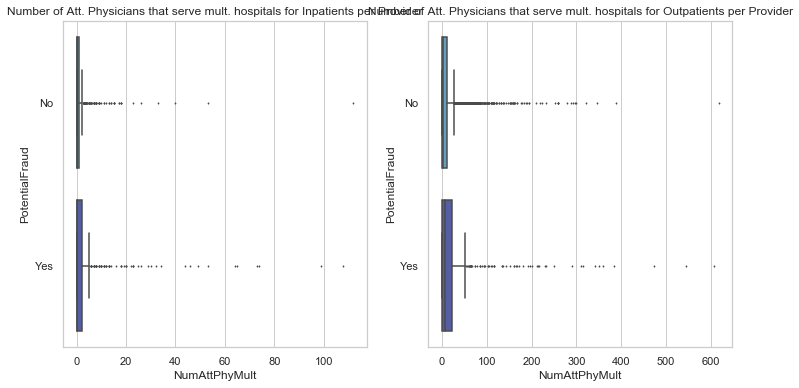

In [38]:
create_boxplot(num_attphy, "NumAttPhyMult",
              "Number of Att. Physicians that serve mult. hospitals for Inpatients per Provider",
              "Number of Att. Physicians that serve mult. hospitals for Outpatients per Provider")

### Do patients go to different hospitals?

In [39]:
# Distribution of the number of unique providers each patient go to
patient.groupby('BeneID')["Provider"].nunique().describe()

count    138556.000000
mean          2.622045
std           1.837349
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          20.000000
Name: Provider, dtype: float64

In [40]:
# Finding patterns of beneficiaries who move around more than 3 hospitals (75% threshold)
nuniq_prov = patient.groupby('BeneID')["Provider"].nunique().reset_index()
bene_more = nuniq_prov[nuniq_prov.Provider > 3].BeneID.tolist()

In [41]:
patient.loc[patient["BeneID"].isin(bene_more),"Bene_Mult"] = 1
patient.loc[~patient["BeneID"].isin(bene_more),"Bene_Mult"] = 0

In [42]:
bene_mult_prov = transform_df('Bene_Mult', 'sum', 'NumBeneMult')

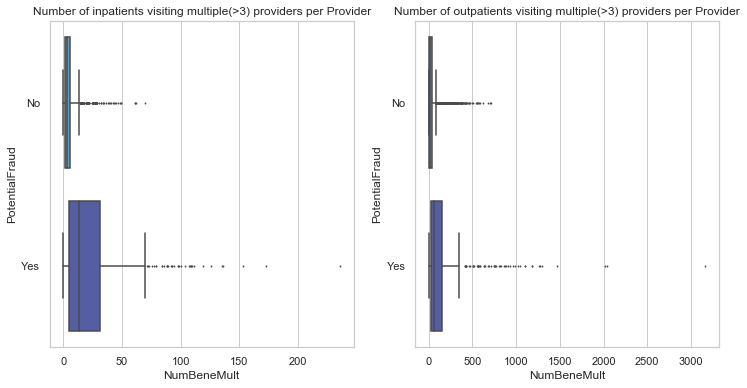

In [43]:
create_boxplot(bene_mult_prov, "NumBeneMult",
              "Number of inpatients visiting multiple(>3) providers per Provider",
              "Number of outpatients visiting multiple(>3) providers per Provider")

### Does the provider provide both inpatient and outpatient services? 

In [44]:
# Unique providers who serve inpatients
prov_inp = inpatient.Provider.unique().tolist()

In [45]:
# providers who provide both inpatient and outpatient services
prov_both = outpatient[outpatient.Provider.isin(prov_inp)].Provider.tolist()

In [46]:
# Boolean column for serving both types of patients
patient.loc[patient["Provider"].isin(prov_both),"Prov_Both"] = 1
patient.loc[~patient["Provider"].isin(prov_both),"Prov_Both"] = 0

In [47]:
num_prov_both = patient.groupby(['PotentialFraud'])[['Prov_Both']].sum()
# Number of claims for PotentialFraud or not
num_prov_both['length'] = \
        [patient[patient['PotentialFraud'] == "No"].shape[0],patient[patient['PotentialFraud'] == "Yes"].shape[0]]
num_prov_both['Prov_Both_Ratio'] = num_prov_both["Prov_Both"]/num_prov_both["length"]
num_prov_both

,Prov_Both,length,Prov_Both_Ratio
PotentialFraud,,,
No,121782.0,345415,0.352567
Yes,134682.0,212796,0.632916


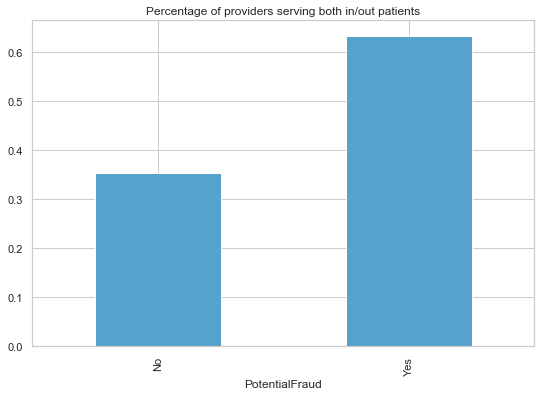

In [48]:
num_prov_both.Prov_Both_Ratio.plot(kind='bar');
plt.title("Percentage of providers serving both in/out patients");

### Do patients receive both inpatient and outpatient services? 

In [49]:
# Unique beneficiaries that receive inpatient service
bene_inp = inpatient.BeneID.unique().tolist()

In [50]:
# Beneficiaries that receive both in/out patient service
bene_both = outpatient[outpatient.BeneID.isin(bene_inp)].BeneID.tolist()

In [51]:
patient.loc[patient["BeneID"].isin(bene_both),"Bene_Both"] = 1
patient.loc[~patient["BeneID"].isin(bene_both),"Bene_Both"] = 0

In [52]:
num_bene_both = patient.groupby(['PotentialFraud'])[['Bene_Both']].sum()
# Number of claims for PotentialFraud or not
num_bene_both['length'] = \
        [patient[patient['PotentialFraud'] == "No"].shape[0],patient[patient['PotentialFraud'] == "Yes"].shape[0]]
num_bene_both['Bene_Both_Ratio'] = num_bene_both["Bene_Both"]/num_bene_both["length"]
num_bene_both

,Bene_Both,length,Bene_Both_Ratio
PotentialFraud,,,
No,94283.0,345415,0.272956
Yes,66599.0,212796,0.312971


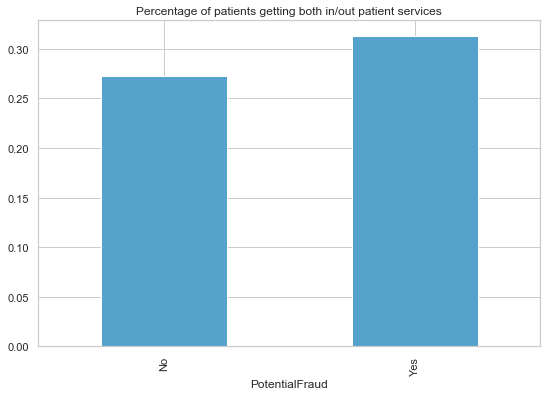

In [53]:
num_bene_both.Bene_Both_Ratio.plot(kind='bar');
plt.title("Percentage of patients getting both in/out patient services");

### Is there a trend in patient age in terms of the count of claims?

In [54]:
bene_age = patient.groupby(['PotentialFraud','AgeAtClm'])[['ClaimID']].count()
bene_age.columns.values[0] = 'Count'
bene_age = bene_age.reset_index()

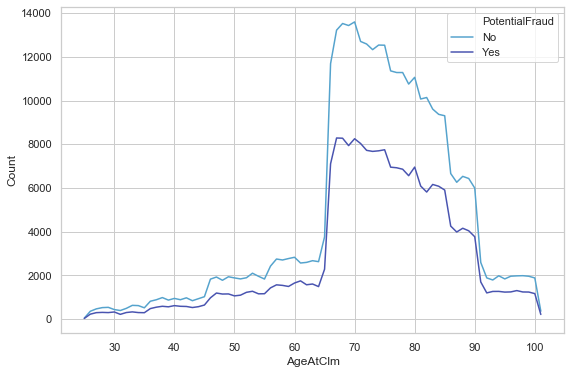

In [55]:
sns.lineplot(data = bene_age,x = "AgeAtClm", y = 'Count', hue='PotentialFraud');

In [56]:
avg_age = transform_df('AgeAtClm', 'mean', 'AvgAge')

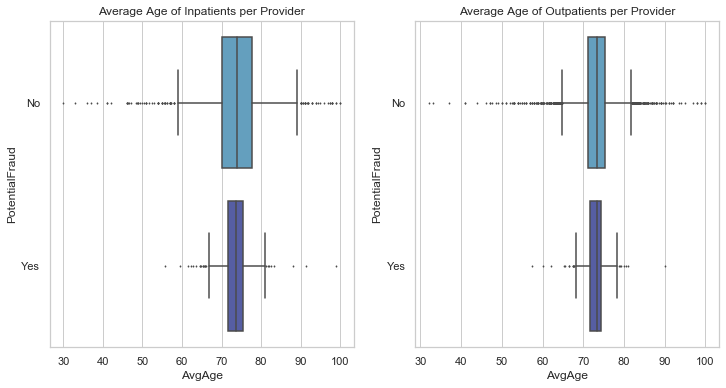

In [57]:
create_boxplot(avg_age, "AvgAge",
              "Average Age of Inpatients per Provider",
              "Average Age of Outpatients per Provider")

### Is the above trend different for patients with different chronic disease?


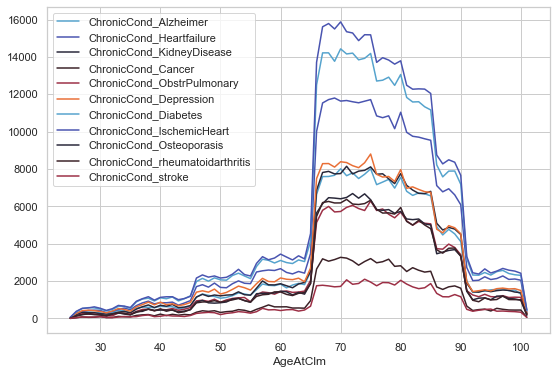

In [58]:
patient.groupby('AgeAtClm')[chronic].sum().plot(kind = 'line');

### Patients with what chronic disease would make more in/outpatient visits?

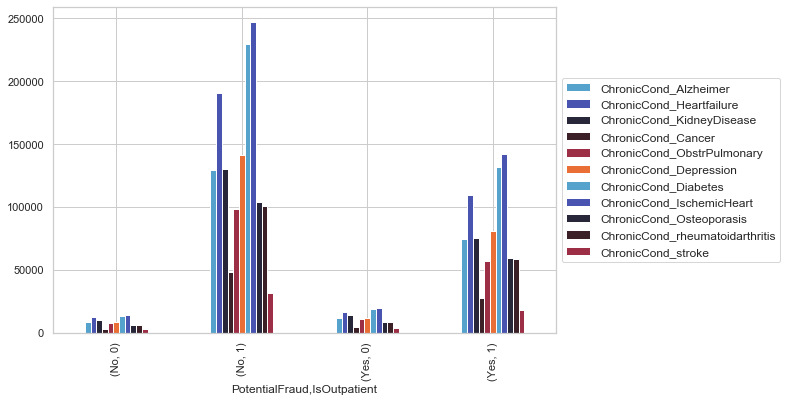

In [59]:
patient.groupby(['PotentialFraud','IsOutpatient'])[chronic].sum().plot(kind = 'bar');
plt.legend(fontsize = 12, bbox_to_anchor=(1,0.8));

### From the prospect of the providers, the sum of reimbursed amounts and deductibles are flowing to the providers. Patients with what type of chronic disease contribute more to the providers?

In [60]:
print("No Potential Fraud")
for col in chronic:
    print('Mean Revenue from', col, ':', 
          round(patient[(patient[col] == 1)&(patient['PotentialFraud'] == "No")][["TotalRev"]].mean()[0],2))

No Potential Fraud
Mean Revenue from ChronicCond_Alzheimer : 926.31
Mean Revenue from ChronicCond_Heartfailure : 936.02
Mean Revenue from ChronicCond_KidneyDisease : 1136.21
Mean Revenue from ChronicCond_Cancer : 956.58
Mean Revenue from ChronicCond_ObstrPulmonary : 1074.88
Mean Revenue from ChronicCond_Depression : 853.71
Mean Revenue from ChronicCond_Diabetes : 880.61
Mean Revenue from ChronicCond_IschemicHeart : 879.87
Mean Revenue from ChronicCond_Osteoporasis : 834.89
Mean Revenue from ChronicCond_rheumatoidarthritis : 863.17
Mean Revenue from ChronicCond_stroke : 1194.84


In [61]:
print("Potential Fraud")
for col in chronic:
    print('Mean Revenue from', col, ':', 
          round(patient[(patient[col] == 1)&(patient['PotentialFraud'] == "Yes")][["TotalRev"]].mean()[0],2))

Potential Fraud
Mean Revenue from ChronicCond_Alzheimer : 1707.72
Mean Revenue from ChronicCond_Heartfailure : 1758.86
Mean Revenue from ChronicCond_KidneyDisease : 2118.92
Mean Revenue from ChronicCond_Cancer : 1872.85
Mean Revenue from ChronicCond_ObstrPulmonary : 2084.93
Mean Revenue from ChronicCond_Depression : 1604.08
Mean Revenue from ChronicCond_Diabetes : 1647.61
Mean Revenue from ChronicCond_IschemicHeart : 1652.27
Mean Revenue from ChronicCond_Osteoporasis : 1591.94
Mean Revenue from ChronicCond_rheumatoidarthritis : 1647.73
Mean Revenue from ChronicCond_stroke : 2336.44


### Is there any weekly trend in the number of claims?

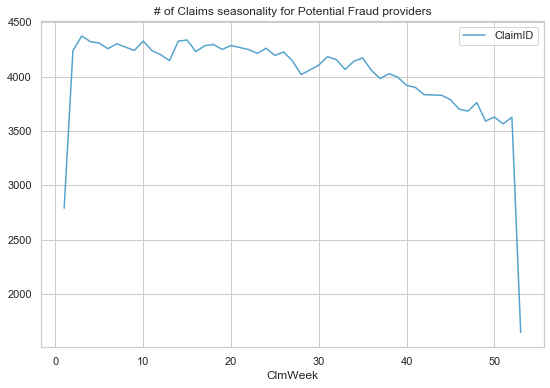

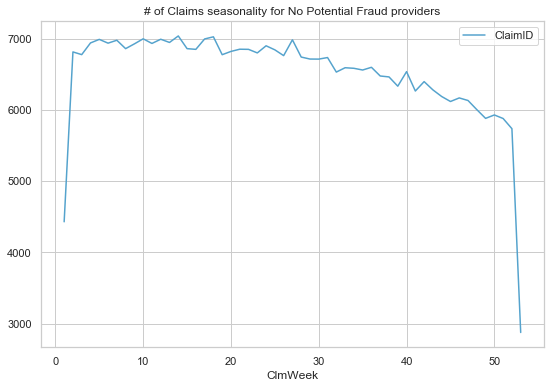

In [62]:
patient[patient.PotentialFraud == "Yes"].groupby('ClmWeek')\
            [['ClaimID']].count().plot(kind='line', title = "# of Claims seasonality for Potential Fraud providers");
patient[patient.PotentialFraud == "No"].groupby('ClmWeek')\
            [['ClaimID']].count().plot(kind='line', title = "# of Claims seasonality for No Potential Fraud providers");

### Is the weekly trend different for in/out patients?

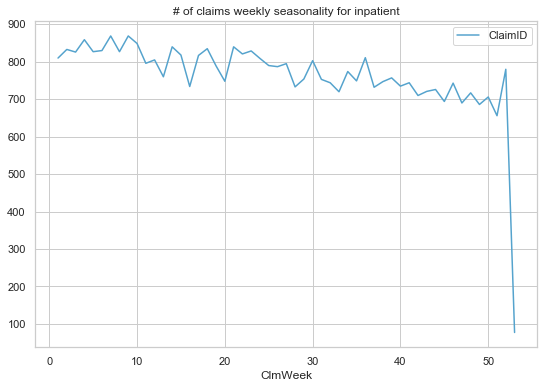

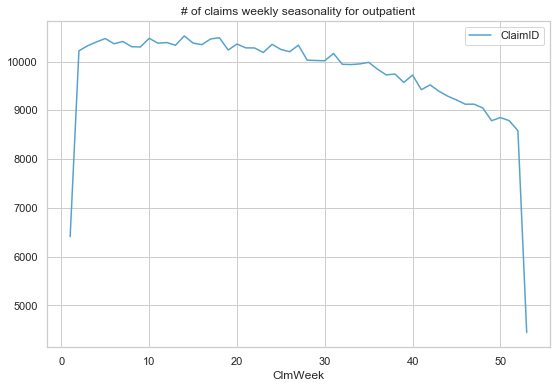

In [63]:
patient[patient.IsOutpatient == 0].groupby('ClmWeek')[['ClaimID']].count().plot(kind='line',
                                                    title="# of claims weekly seasonality for inpatient");
patient[patient.IsOutpatient == 1].groupby('ClmWeek')[['ClaimID']].count().plot(kind='line',
                                                    title="# of claims weekly seasonality for outpatient");

### What are the top 5 most frequent ClmAdmitDiagnosisCodes from PotentialFraud providers?

In [64]:
# Top 5 most frequent code from Potential Fraud claims
patient[patient['PotentialFraud']=='Yes'].groupby('ClmAdmitDiagnosisCode')['ClaimID'].count().sort_values()

ClmAdmitDiagnosisCode
0030        1
37102       1
37033       1
37020       1
37003       1
         ... 
78900    1020
78650    1191
78605    1432
V7612    1441
42731    1529
Name: ClaimID, Length: 3146, dtype: int64

In [65]:
topfive = ["78900", "78650", "78605", "V7612", "42731"]

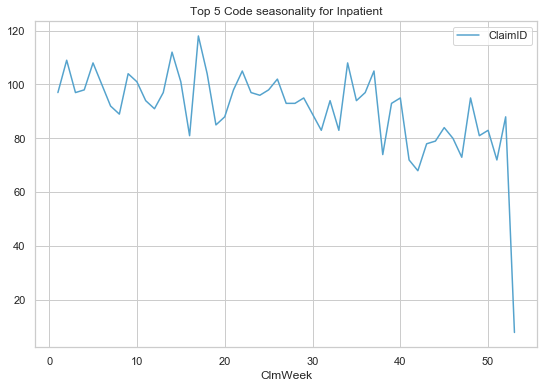

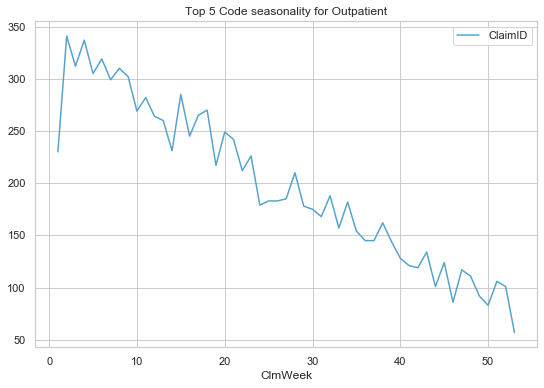

In [66]:
patient[(patient.IsOutpatient == 0)&(patient['ClmAdmitDiagnosisCode'].isin(topfive))].groupby(
    'ClmWeek')[['ClaimID']].count().plot(kind='line', title = 'Top 5 Code seasonality for Inpatient');
patient[(patient.IsOutpatient == 1)&(patient['ClmAdmitDiagnosisCode'].isin(topfive))].groupby(
    'ClmWeek')[['ClaimID']].count().plot(kind='line', title = 'Top 5 Code seasonality for Outpatient');

### For inpatients, is there any pattern between the admission durations and the type of chronic disease?

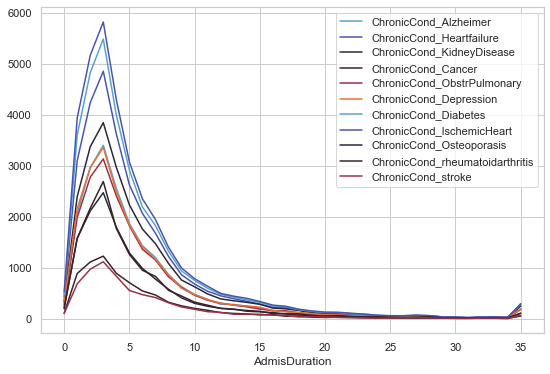

In [67]:
patient[patient['IsOutpatient'] == 0].groupby('AdmisDuration')[chronic].sum().plot(kind= 'line');

### Is there any pattern in the monthly count of in/out patients?


In [68]:
table = pd.pivot_table(patient, values='ClaimID', index=['ClmYear', 'ClmMonth'],
                    columns=['IsOutpatient'], aggfunc= 'count')
table

IsOutpatient           0        1
ClmYear ClmMonth                 
2008    11           6.0      NaN
        12         680.0   2019.0
2009    1         3731.0  45851.0
        2         3375.0  41416.0
        3         3587.0  46047.0
        4         3427.0  44657.0
        5         3569.0  45690.0
        6         3467.0  43933.0
        7         3371.0  44677.0
        8         3329.0  44181.0
        9         3238.0  41662.0
        10        3232.0  41872.0
        11        3014.0  39082.0
        12        2448.0  36650.0

### Is there a trend in insurance covered percentages? InscClaimAmtReimbursed/(InscClaimAmtReimbursed+DeductibleAmtPaid).

In [69]:
avg_inscov = transform_df('InsCovRatio', 'mean', 'AvgInsCovRatio')

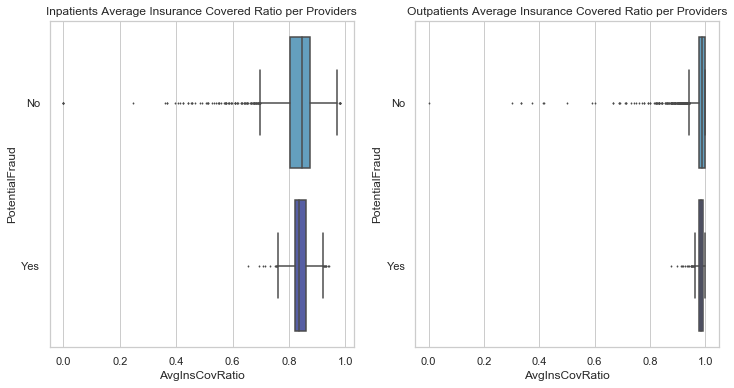

In [70]:
create_boxplot(avg_inscov, "AvgInsCovRatio",
              "Inpatients Average Insurance Covered Ratio per Providers",
              "Outpatients Average Insurance Covered Ratio per Providers")

### How are the service durations related to the total revenue?

In [71]:
dur_rev = patient.groupby(['PotentialFraud','IsOutpatient','Provider'])[['TotalRev','ClaimDuration']].\
                agg({"TotalRev":'sum',"ClaimDuration": 'mean'})
dur_rev.columns.values[0] = 'TotalRev'
dur_rev.columns.values[1] = 'AvgClaimDur'
dur_rev = dur_rev.reset_index()

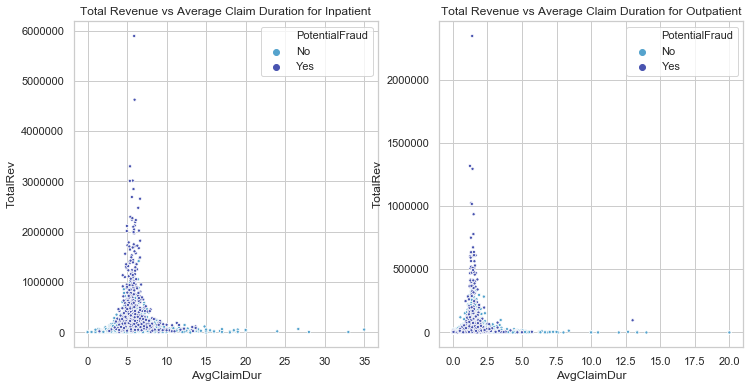

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.scatterplot(data = dur_rev[dur_rev['IsOutpatient'] == 0], 
            x = "AvgClaimDur", y = 'TotalRev', hue = 'PotentialFraud', s = 10, ax = ax[0]);
sns.scatterplot(data = dur_rev[dur_rev['IsOutpatient'] == 1], 
            x = "AvgClaimDur", y = 'TotalRev', hue = 'PotentialFraud', s = 10, ax = ax[1]);
ax[0].set_title("Total Revenue vs Average Claim Duration for Inpatient");
ax[1].set_title("Total Revenue vs Average Claim Duration for Outpatient");

### Is there any pattern for average revenue per day?

In [73]:
avg_revperday = transform_df('RevPerDay', 'mean', 'AvgRevPerDay')

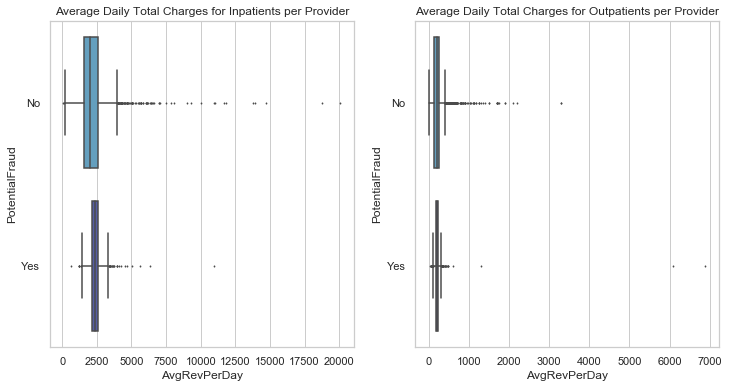

In [74]:
create_boxplot(avg_revperday, "AvgRevPerDay",
              "Average Daily Total Charges for Inpatients per Provider",
              "Average Daily Total Charges for Outpatients per Provider")

### Is there any duplicate claim for in/out patients, in terms of having the exact same DiagnosisCode + ProcedureCode within the same Provider?
* While having the same diagnosis codes does not necessarily mean they are duplicated claims, with the prevalence of such claims, it could be a signal for fradulent claims.

In [75]:
# Excluding the claims with no diagnosis or procedure codes
patient['code_all_nan'] = patient[diag_code + proc_code].isna().all(axis = 1)
notnan = patient[patient['code_all_nan']== 0]
# Creating a new list column for the columns used to discern duplicates
notnan['duplicate'] = notnan[['Provider'] + diag_code + proc_code].values.tolist()
# Removing NaNs from the list column
notnan['duplicate'] = notnan['duplicate'].apply(lambda x: [code for code in x if str(code) != "nan"])
# # notnan['duplicate'] = notnan['duplicate'].apply(lambda x: sorted(x))

# Creating a boolean column for duplicate claims
notnan['duplicate_bool'] = hashable_df(notnan).duplicated(subset = ['duplicate'], keep = False)

/Users/hb/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/hb/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/hb/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [76]:
dup_same_prov = notnan.groupby(['PotentialFraud','IsOutpatient'])[['duplicate_bool']].sum()/notnan.shape[0]
dup_same_prov.columns.values[0] = 'Duplicate_Ratio'
dup_same_prov = dup_same_prov.reset_index()

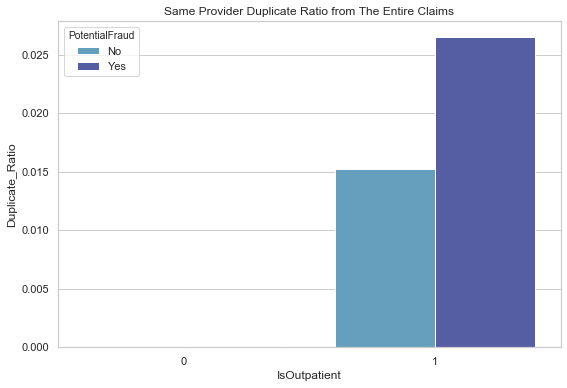

In [77]:
sns.barplot(data = dup_same_prov, x = 'IsOutpatient', y = 'Duplicate_Ratio', hue = 'PotentialFraud');
plt.title("Same Provider Duplicate Ratio from The Entire Claims");

### What about providers using records from other providers?

In [78]:
# Index of the duplicates that were from the same providers
from_same_prov = notnan[notnan['duplicate_bool'] == 1].index

In [79]:
# Excluding the same provider duplicates
notnan = notnan.loc[~notnan.index.isin(from_same_prov)]
# Re-creating the list column for duplicates for claims made from different providers
notnan['duplicate'] = notnan[diag_code + proc_code].values.tolist()
# Removing NaNs from the list column of duplicates
notnan['duplicate'] = notnan['duplicate'].apply(lambda x: [code for code in x if str(code) != "nan"])
# # notnan['duplicate'] = notnan['duplicate'].apply(lambda x: sorted(x))
notnan['duplicate_bool'] = hashable_df(notnan).duplicated(subset = ['duplicate'], keep = False)

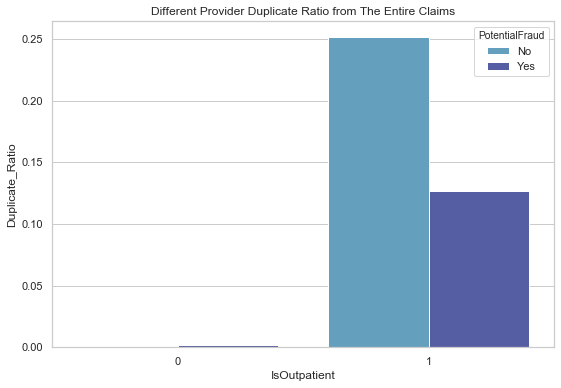

In [80]:
dup_diff_prov = notnan.groupby(['PotentialFraud','IsOutpatient'])[['duplicate_bool']].sum()/notnan.shape[0]
dup_diff_prov.columns.values[0] = 'Duplicate_Ratio'
dup_diff_prov = dup_diff_prov.reset_index()
sns.barplot(data = dup_diff_prov, x = 'IsOutpatient', y = 'Duplicate_Ratio', hue = 'PotentialFraud');
plt.title("Different Provider Duplicate Ratio from The Entire Claims");

### Is the distribution of duplicate claims different for potentially fradulent/not fraudulent providers?

In [81]:
notnan = patient[patient['code_all_nan']== 0]
# Creating a new list column for the columns used to discern duplicates
notnan['duplicate'] = notnan[diag_code + proc_code].values.tolist()
# Removing NaNs from the list column
notnan['duplicate'] = notnan['duplicate'].apply(lambda x: [code for code in x if str(code) != "nan"])
# # notnan['duplicate'] = notnan['duplicate'].apply(lambda x: sorted(x))

# Creating a boolean column for duplicate claims
notnan['duplicate_bool'] = hashable_df(notnan).duplicated(subset = ['duplicate'], keep = False)

/Users/hb/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/hb/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/hb/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [83]:
dup_ratio = notnan.groupby(['PotentialFraud','IsOutpatient','Provider'])[['duplicate_bool']].agg('mean')
dup_ratio.columns.values[0] = 'Mean_Duplicate_Ratio'
dup_ratio = dup_ratio.reset_index()

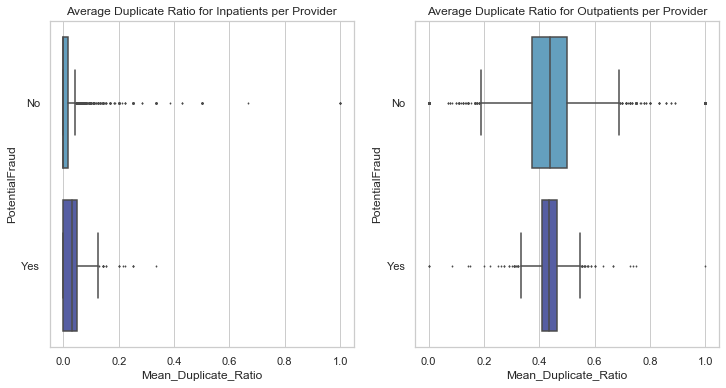

In [84]:
create_boxplot(dup_ratio, "Mean_Duplicate_Ratio",
              "Average Duplicate Ratio for Inpatients per Provider",
              "Average Duplicate Ratio for Outpatients per Provider")

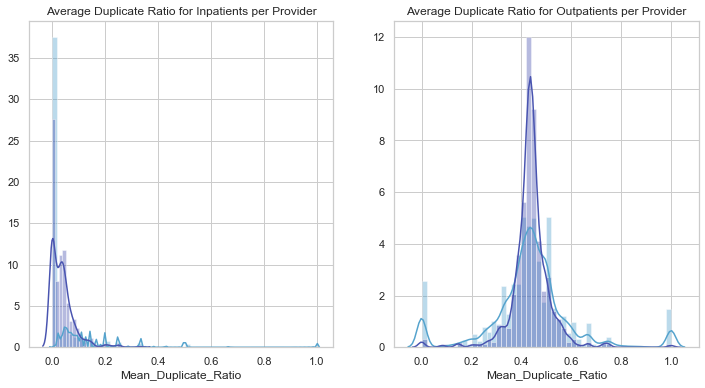

In [85]:
# Another Visualization of Duplicates Distribution for In/Out Patients
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.distplot(dup_ratio.loc[(dup_ratio['IsOutpatient'] == 0) & (dup_ratio['PotentialFraud'] == "No"),
                         "Mean_Duplicate_Ratio"], label = "Not Fraud", ax = ax[0]);
sns.distplot(dup_ratio.loc[(dup_ratio['IsOutpatient'] == 0) & (dup_ratio['PotentialFraud'] == "Yes"),
                         "Mean_Duplicate_Ratio"], label = "Potential Fraud", ax = ax[0]);
sns.distplot(dup_ratio.loc[(dup_ratio['IsOutpatient'] == 1) & (dup_ratio['PotentialFraud'] == "No"),
                         "Mean_Duplicate_Ratio"], label = "Not Fraud", ax = ax[1]);
sns.distplot(dup_ratio.loc[(dup_ratio['IsOutpatient'] == 1) & (dup_ratio['PotentialFraud'] == "Yes"),
                         "Mean_Duplicate_Ratio"], label = "Potential Fraud", ax = ax[1]);
ax[0].set_title("Average Duplicate Ratio for Inpatients per Provider");
ax[1].set_title("Average Duplicate Ratio for Outpatients per Provider");

### For the duplicate claims, how does the value_counts() look like?

In [86]:
dup_counts = hashable_df(notnan[notnan['duplicate_bool'] == 1])['duplicate'].value_counts()

### Do these duplicate claims show any anomaly in terms of geographic locations? 

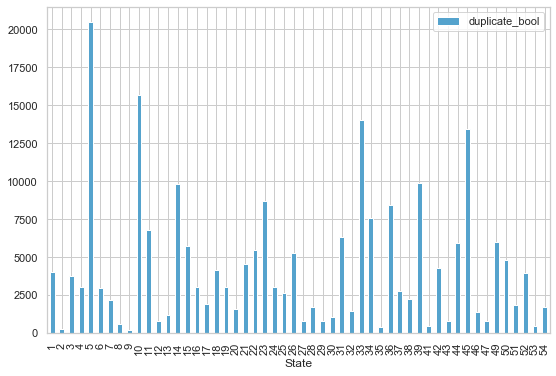

In [87]:
notnan.groupby('State')[['duplicate_bool']].sum().plot(kind = 'bar');

### In average, how many chronic symptoms do patients have?

In [88]:
chronic_sum = transform_df('Chronic_Sum', 'mean', 'Mean_Numb_Chronic')

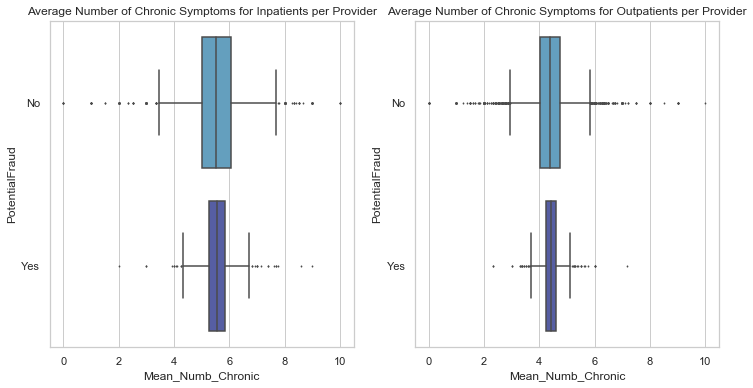

In [89]:
create_boxplot(chronic_sum, "Mean_Numb_Chronic",
              "Average Number of Chronic Symptoms for Inpatients per Provider",
              "Average Number of Chronic Symptoms for Outpatients per Provider")

### Any pattern for claims with no diagnosis or procedure code?

In [90]:
patient['code_all_nan'] = patient[diag_code + proc_code].isna().all(axis = 1)
patient['code_all_nan'].describe()

count     558211
unique         2
top        False
freq      549892
Name: code_all_nan, dtype: object

In [91]:
code_all_nan = transform_df('code_all_nan', 'mean', 'Mean_code_all_nan')

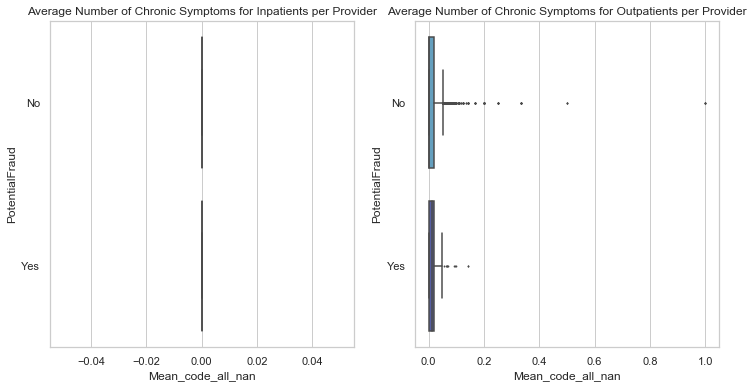

In [92]:
create_boxplot(code_all_nan, "Mean_code_all_nan",
              "Average Number of Chronic Symptoms for Inpatients per Provider",
              "Average Number of Chronic Symptoms for Outpatients per Provider")

## Missing Values

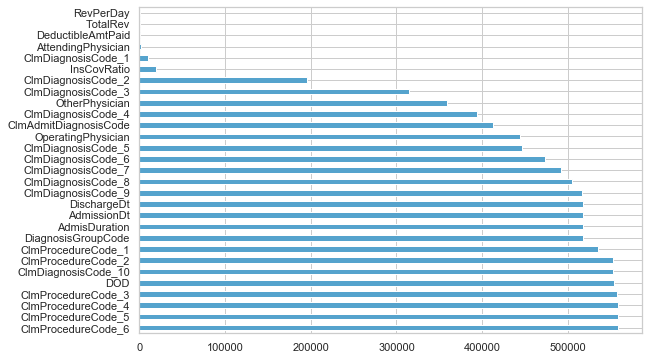

In [93]:
missing = pd.DataFrame(patient.isna().sum().sort_values(ascending = False), columns = ["Count_NaN"])
missing[missing["Count_NaN"] > 0].plot(kind= 'barh',legend = None);

In [94]:
missing[missing['Count_NaN'] > 0 ]

,Count_NaN
ClmProcedureCode_6,558211
ClmProcedureCode_5,558202
ClmProcedureCode_4,558093
ClmProcedureCode_3,557242
DOD,554080
ClmDiagnosisCode_10,553201
ClmProcedureCode_2,552721
ClmProcedureCode_1,534901
DiagnosisGroupCode,517737
AdmisDuration,517737
